# Concussion Claims Tracking


In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import scikit_vectorizer, PorterTokenizer, get_stopwords, sql_connection
from concussion import get_relevant_claims, get_full_claims_data
sns.set_theme(style="darkgrid")

In [3]:
key_words = ['concussion', 'cranial', 'brain',
             'head', 'headache', 'migraine', 'dizzy',
             'dizziness', 'fatigue', 'insomnia']

In [15]:
# Get Claims Data, format

engine = sql_connection('BASAPOPRDSQLV20', 'Apollo_Reporting')
df_scm = pd.read_sql_query("SELECT ClaimDetailID, LossDescription, LossLocation from V_LMMData_SCM", engine)
df_cgen = pd.read_sql_query("SELECT ClaimDetailID, ClaimAdvisedDate, HandlingClass, UnderwritingYear from V_ClaimData_General", engine)

df_scm.drop_duplicates(subset=['ClaimDetailID'], keep='last', inplace=True)
df = df_scm.merge(df_cgen, how="left", on='ClaimDetailID')


In [17]:
df.columns = ['claim_id', 'documents', 'loss_location', 'date', 'class', 'underwriting_year']
df = df[['date', 'underwriting_year', 'loss_location', 'claim_id', 'class', 'documents']]
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

In [18]:
df.head()

,date,underwriting_year,loss_location,claim_id,class,documents
0,2021-06-04 00:00:00,2019.0,"I75 85 N, ATLANTA, GA",96742.0,Rover,CLMNT:ABIDEMI OGUNBODE-VEHICLE INCIDENT.
1,2017-12-15 00:00:00,2016.0,YANTIAN NICARAGUA,48446.0,Specie & Miscellaneous,DAMAGE FEES
2,2018-01-12 00:00:00,2016.0,TBA,49331.0,Aviation,AEROFLOT OPERATING - DAMAGE TO THE TIP OF THE ...
3,2021-02-11 00:00:00,2020.0,"MENA, AR",93092.0,Non Marine Liability,HUMAN REMAINS WERE FOUND IN A FREEZER THAT WAS...
4,2017-07-31 09:42:10,2016.0,"PORT EVERGLADES , FLORIDA TO RIO HAINA, DOM REP",42210.0,Specie & Miscellaneous,CARRIER RELEASED CARGO CON...


In [24]:
# Get claims with key words in

stop_words_combined = get_stopwords()
vectorizer = scikit_vectorizer(stop_words_combined, PorterTokenizer, CountVectorizer)
relevant_claims, df_relevant_claims = get_relevant_claims(df, vectorizer)

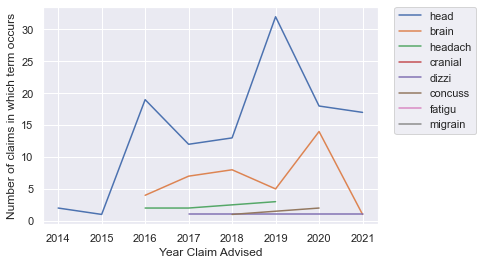

In [45]:
# Plots here

graph_data_1 = relevant_claims.groupby([relevant_claims.date.dt.year,'term'], as_index=True).sum().reset_index()
graph_data_1.head(15)
ax = sns.lineplot(x=graph_data_1.date, y=graph_data_1.mentions, hue=graph_data_1.term)
ax.set(xlabel='Year Claim Advised', ylabel='Number of claims in which term occurs')
plt.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Full claims data for relative numbers

df_claims = get_full_claims_data(engine)